In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN,LSTM, Dropout
from keras.optimizers import Adam

In [23]:
# Charger les données
df = pd.read_csv("bitcoin_data.csv")

# Convertir la colonne 'date' en format datetime
df["date"] = pd.to_datetime(df["date"])

# Définir 'date' comme index
df.set_index("date", inplace=True)

# Supprimer les colonnes indésirables
df = df.drop(columns=["Unnamed: 0"])

In [24]:
# Préparer les données (prix de clôture)
data = df["close"].values
data = data.reshape(-1, 1)

In [27]:
# Normaliser les données
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

In [28]:
# Diviser les données en ensembles d'entraînement et de test
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train, test = data[0:train_size, :], data[train_size:len(data), :]

# Préparation des séquences
def create_sequences(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_sequences(train, time_step)
X_test, y_test = create_sequences(test, time_step)

# Reshape les entrées pour être [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [29]:
# Proposition d'architecture RNN
model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(SimpleRNN(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)


C:\Users\hp\anaconda3\Lib\site-packages\keras\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0109 - val_loss: 0.0235
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 9.7607e-04 - val_loss: 0.0238
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 7.2010e-04 - val_loss: 0.0123
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 4.9711e-04 - val_loss: 0.0051
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 4.4847e-04 - val_loss: 0.0076
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3.3463e-04 - val_loss: 0.0023
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.8624e-04 - val_loss: 0.0035
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.4699e-04 - val_loss: 0.0025
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.3182e-04 - val_loss: 0.0029
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 2.1621e-04 - val_loss: 0.0027
Epoch 11/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.8802e-04 - val_loss: 0.0014
Epoch 12/10

In [30]:
# Prédictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverser la normalisation pour les prédictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [31]:
# Calcul de l'erreur quadratique moyenne
train_score = np.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
test_score = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
print(f"RMSE Train: {train_score}, RMSE Test: {test_score}")

RMSE Train: 321.0454229293597, RMSE Test: 2297.7211855704063


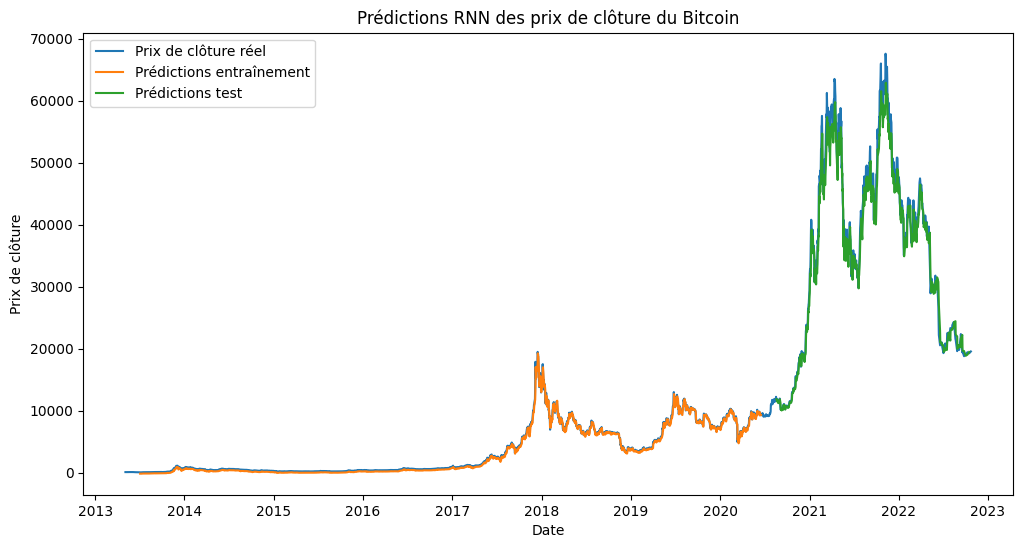

In [32]:
# Visualisation des résultats
plt.figure(figsize=(12, 6))
plt.plot(df.index, scaler.inverse_transform(data), label='Prix de clôture réel')
plt.plot(df.index[time_step:len(train_predict) + time_step], train_predict, label='Prédictions entraînement')
plt.plot(df.index[len(train_predict) + (time_step * 2) + 1:len(data) - 1], test_predict, label='Prédictions test')
plt.xlabel('Date')
plt.ylabel('Prix de clôture')
plt.title('Prédictions RNN des prix de clôture du Bitcoin')
plt.legend()
plt.show()